**Изучение спектров ЕРЭ**


In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from scipy import linalg as la 

**Загрузим  данные об идеальных спектрах**

In [2]:
#Пропускаем первую строку, чтобы не было конфликта размеров колонок(в первой строке 6 колонок во второй 1031) и выставляем параметр header=None, чтобы наименования столбцов были численными
sp_k = pd.read_csv(filepath_or_buffer='C:\\Users\\mypos\\Desktop\\Обучение\\Петрофизика\\Белохиин спектры\\k.mdb.csv', sep=' ',header=None, skiprows=1)
sp_u = pd.read_csv(filepath_or_buffer='C:\\Users\\mypos\\Desktop\\Обучение\\Петрофизика\\Белохиин спектры\\u.mdb.csv', sep=' ',header=None, skiprows=1)
sp_th= pd.read_csv(filepath_or_buffer='C:\\Users\\mypos\\Desktop\\Обучение\\Петрофизика\\Белохиин спектры\\th.mdb.csv', sep=' ', header=None, skiprows=1)


**Предобработаем полученные файлы**

In [15]:
#Пропускаем каждую вторую строку, так как они не являются информативными и будут содержать большое кол-во NaN значений, а также убираем лишние столбы(первые 5 и последний)
df_k = sp_k[0::2].drop(columns=[x for x in range(6)]).drop(columns=[sp_k.columns[-1]])
df_u = sp_u[0::2].drop(columns=[x for x in range(6)]).drop(columns=[sp_u.columns[-1]])
df_th = sp_th[0::2].drop(columns=[x for x in range(6)]).drop(columns=[sp_th.columns[-1]])

**Проверим размерности полученных фреймов -- они должны совпадать с количеством каналов(1024)**

In [16]:
print(df_k.shape, df_u.shape, df_th.shape, sep='\n\n')

(10, 1024)

(10, 1024)

(10, 1024)


**Суммируем полученные значения**

In [17]:
#параметр axis=0 по умолчаниию, это значит, что суммировать будет строки
summary_k = df_k.sum()
summary_u = df_u.sum()
summary_th = df_th.sum()

**Посмотрим на графики полученных идеальных спектров**

Text(0, 0.5, 'Intensivity')

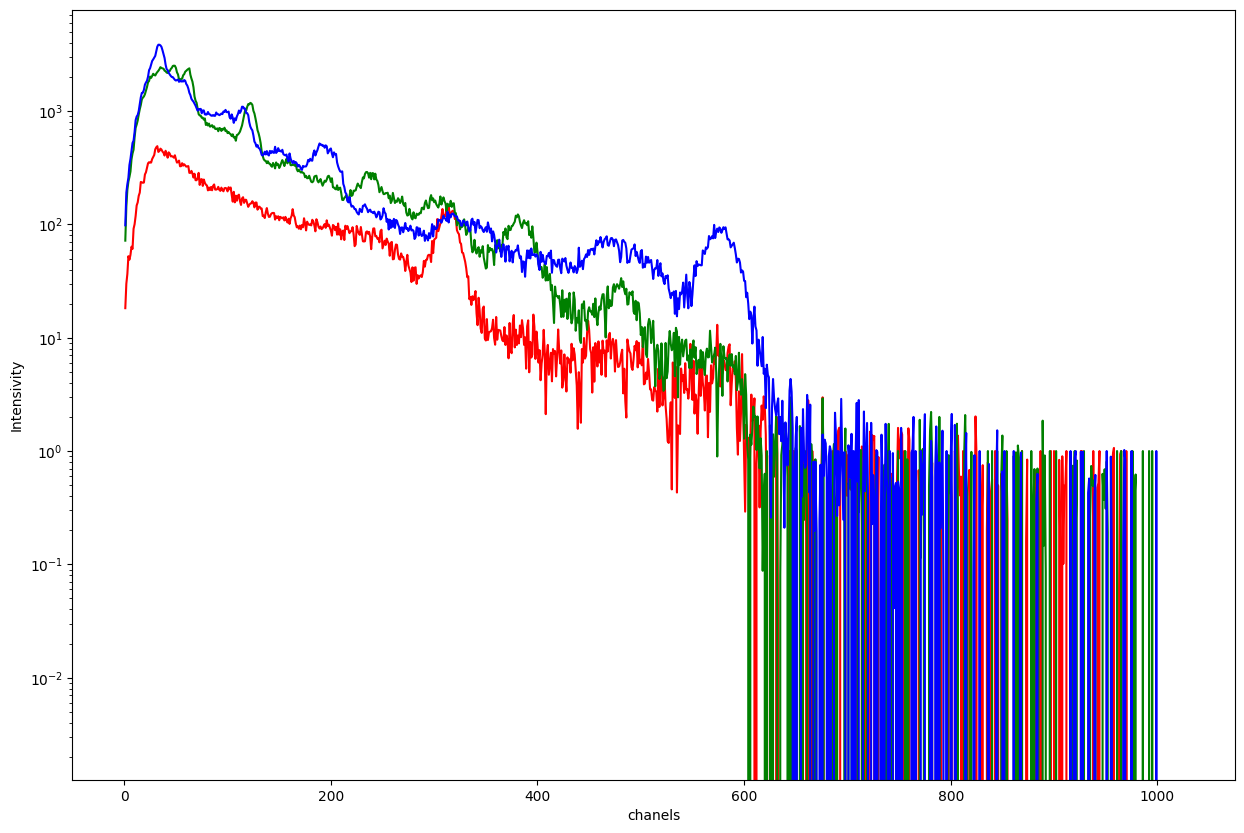

In [18]:
chanels = list(range(1,1025))

plt.figure(figsize=(15,10))
plt.plot(chanels, summary_k, c = 'r')
plt.plot(chanels, summary_u, c = 'g')
plt.plot(chanels, summary_th, c = 'b')
plt.yscale('log')
plt.xlabel('chanels')
plt.ylabel('Intensivity')

In [19]:
#Создадим матрицу с полученными спектрами
df_all_spectra = np.vstack((summary_k, summary_u, summary_th))
df_all_spectra.shape

(3, 1024)

**Загрузим измеренные на керне данные и выполним предобработку**

In [20]:
sp_q = pd.read_csv(filepath_or_buffer='C:\\Users\\mypos\\Desktop\\Обучение\\Петрофизика\\Белохиин спектры\\quest.mdb.csv', sep=' ',header=None, skiprows=1)
df_q = sp_q[::2].drop(columns=[x for x in range(6)]).drop(columns=[sp_q.columns[-1]])
df_q.shape




(52, 1024)

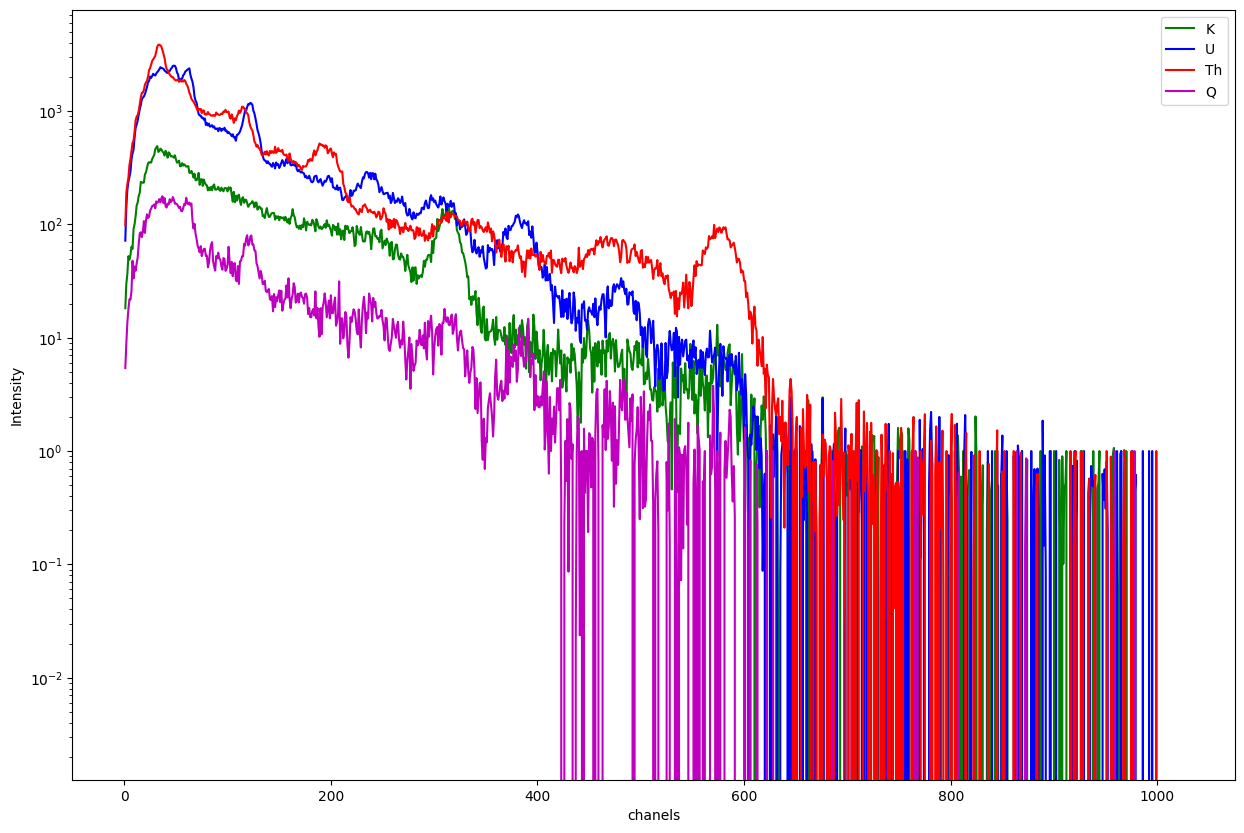

In [21]:
chanels = list(range(1,1025))

plt.figure(figsize=(15,10))
plt.plot(chanels, summary_k, label= 'K', c = 'g')
plt.plot(chanels, summary_u, label= 'U', c = 'b')
plt.plot(chanels, summary_th, label= 'Th', c = 'r')
plt.plot(chanels, df_q[1:2].T, label= 'Q', c = 'm')
plt.yscale('log')
plt.xlabel('chanels')
plt.ylabel('Intensity')
plt.legend(fontsize=10)

**Посчитаем концентрации по формуле**

## (S.T * S) ^ (-1) * S.T * Q = C

### где, S -- спектры отдельных ЕРЭ, Q -- измеренный спектр, C -- концентрации

In [ ]:
df_all_spectra = df_all_spectra.T
df_all_spectra.shape
df_q = df_q.T

(1024, 3)

In [31]:
df_q.shape

(1024, 52)

In [24]:
df_all_spectra.shape

(1024, 3)

**Используем функцию из scipy -- lstsq**

In [32]:
conc, residuals, rank, s= la.lstsq(df_all_spectra, df_q)

**Проверим размерность**

In [33]:
conc.shape

(3, 52)

**Построим график для полученных конценраций**

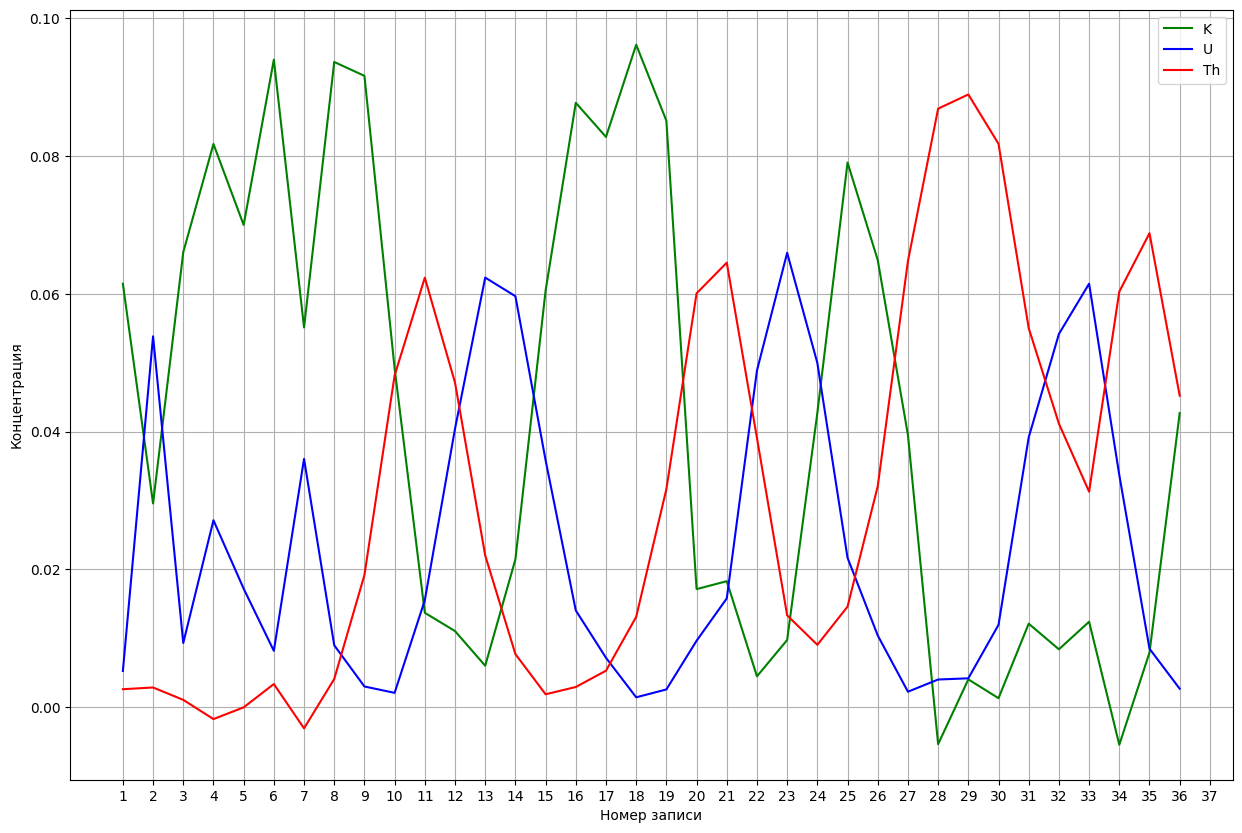

In [35]:
conc_k = conc[0]
conc_u = conc[1]
conc_th = conc[2]
records = list(range(1, 37))

plt.figure(figsize=(15,10))
#Убираем также 40см в начале и конце измерений
plt.plot(records, conc_k[8:44], label = 'K', c = 'g')
plt.plot(records, conc_u[8:44], label = 'U', c = 'b')
plt.plot(records, conc_th[8:44], label = 'Th', c = 'r')
plt.xticks(range(1,38))
plt.grid()
plt.xlabel('Номер записи')
plt.ylabel('Концентрация')
plt.legend(fontsize=10)

In [41]:
conc_new = conc.T[8:44]
conc_new.shape

(36, 3)

**Определим какие ЕРЭ содержатся в каждом образце с помощью взвешенного среднего**

In [ ]:

data = conc_new

sample_length = 12  # Длина образца в см
interval_length = 5  # Интервал измерений в см

num_samples = int(180 / sample_length)  # 15 образцов

# Для хранения преобладающих элементов
predominant_elements = []

# Проходим по каждому образцу
for sample_idx in range(num_samples):
    # Определяем начальную и конечную позиции образца
    start_pos = sample_idx * sample_length
    end_pos = start_pos + sample_length

    # Для хранения взвешенных сумм и весов
    weighted_sum = np.zeros(3)  # Для K, U, Th
    total_weight = 0

    # Проходим по всем интервалам измерений
    for interval_idx in range(len(data)):
        # Определяем начальную и конечную позиции интервала
        interval_start = interval_idx * interval_length
        interval_end = interval_start + interval_length

        # Вычисляем перекрытие между образцом и интервалом
        overlap_start = max(start_pos, interval_start)
        overlap_end = min(end_pos, interval_end)
        overlap_length = max(0, overlap_end - overlap_start)

        # Если есть перекрытие, добавляем вклад в взвешенное среднее
        if overlap_length > 0:
            weight = overlap_length
            weighted_sum += data[interval_idx] * weight
            total_weight += weight

    # Вычисляем взвешенное среднее
    if total_weight > 0:
        weighted_mean = weighted_sum / total_weight
    else:
        weighted_mean = np.zeros(3)  # Если нет перекрытия

    predominant_element = np.argmax(weighted_mean)

    predominant_elements.append(predominant_element)

# Преобразуем индексы в названия элементов
element_names = ['K', 'U', 'Th']
predominant_elements = [element_names[idx] for idx in predominant_elements]

print("Преобладающие элементы в каждом образце:", predominant_elements)

Преобладающие элементы в каждом образце: ['K', 'K', 'K', 'K', 'Th', 'U', 'K', 'K', 'Th', 'U', 'K', 'Th', 'Th', 'U', 'Th']
